In [45]:
!pip install pysd
%pylab inline
import pysd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm
model = pysd.read_vensim('/content/bass.MDL')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy



In [46]:
model = pysd.load('/content/bassnew.py')
model.run(return_columns=['potential_customers'])

,potential_customers
time,
0.0,100000.000000
0.5,99890.000000
1.0,99779.238828
1.5,99667.716264
2.0,99555.432219
...,...
498.0,62158.754612
498.5,62158.703992
499.0,62158.653815


In [47]:
import pandas as pd
pd.set_option('display.max_columns', None)
values = model.run()
#values

**Нормализуем данные**

In [48]:
data = model.run(return_columns=['Potential Customers', 'Customers', 'Customers Competitors'])
base_value = 100000
normalized_data = data / base_value
normalized_data['change_potential'] = normalized_data['Potential Customers'].diff().abs()
normalized_data['change_customers'] = normalized_data['Customers'].diff().abs()
normalized_data['change_competitors'] = normalized_data['Customers Competitors'].diff().abs()

In [49]:
normalized_data

,Potential Customers,Customers,Customers Competitors,change_potential,change_customers,change_competitors
time,,,,,,
0.0,1.000000,0.000000,0.000000,NaN,NaN,NaN
0.5,0.998900,0.000550,0.000550,1.100000e-03,5.500000e-04,0.000550
1.0,0.997792,0.001101,0.001107,1.107612e-03,5.507504e-04,0.000557
1.5,0.996677,0.001652,0.001671,1.115226e-03,5.514589e-04,0.000564
2.0,0.995554,0.002204,0.002241,1.122840e-03,5.521249e-04,0.000571
...,...,...,...,...,...,...
498.0,0.621588,0.032534,0.345878,5.106718e-07,5.268332e-07,0.000001
498.5,0.621587,0.032534,0.345879,5.062012e-07,5.222312e-07,0.000001
499.0,0.621587,0.032533,0.345880,5.017698e-07,5.176694e-07,0.000001


**В качестве порогового значения для оценки сходимости берется значение строгой сходимости, для оценки cходимости модели используется MAE**

In [50]:
import numpy as np
import pandas as pd
def calculate_absolute_error(data: np.ndarray, reference_value: float) -> float:
    return np.abs(data - reference_value).mean()
threshold_value = 1e-6
normalized_data['MAE_Customers'] = normalized_data['change_customers'].rolling(window=10, min_periods=1).apply(
    calculate_absolute_error, args=(threshold_value,), raw=True
)
normalized_data['MAE_Competitors'] = normalized_data['change_competitors'].rolling(window=10, min_periods=1).apply(
    calculate_absolute_error, args=(threshold_value,), raw=True
)
normalized_data['Customers_Converged'] = normalized_data['MAE_Customers'].apply(lambda x: x < 1e-6)
normalized_data['Competitors_Converged'] = normalized_data['MAE_Competitors'].apply(lambda x: x < 1e-6)

**Посмотрим на сходимость метрики MAE.**

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if normalized_data['Customers'].empty or normalized_data['Customers Competitors'].empty:
    print("Error: No data available for Customers or Competitors.")
else:
    final_customers = normalized_data['Customers'].iloc[-1]
    final_competitors = normalized_data['Customers Competitors'].iloc[-1]
    if pd.isna(final_customers) or pd.isna(final_competitors):
        print("Error: Final values are NaN.")
    else:
        print(f'Доли рынка после сходимости составляют Customers: {final_customers:.3f} и Competitors: {final_competitors:.3f}.' )

# Создаем фигуру с двумя осями Y
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Добавляем график для клиентов
fig.add_trace(
    go.Scatter(
        x=normalized_data.index,
        y=normalized_data["Customers"],
        name="Our Customers",
        line=dict(color="purple", dash="dash"),
        opacity=0.7,
    ),
    secondary_y=False,
)

# Добавляем график для клиентов конкурентов
fig.add_trace(
    go.Scatter(
        x=normalized_data.index,
        y=normalized_data["Customers Competitors"],
        name="Competitors' Customers",
        line=dict(color="blue", dash="dash"),
        opacity=0.7,
    ),
    secondary_y=False,
)

# Добавляем scatter-график для MAE клиентов
fig.add_trace(
    go.Scatter(
        x=normalized_data.index,
        y=normalized_data["MAE_Customers"],
        name="Customer MAE",
        mode="markers",
        marker=dict(
            color=normalized_data["Customers_Converged"].map({False: "red", True: "green"}),
            size=8,
            symbol="x",
        ),
    ),
    secondary_y=True,
)

# Настройка осей и заголовка
fig.update_layout(
    title="Сходимость по MAE",
    xaxis_title="Шаг",
    yaxis_title="Количество Клиентв",
    yaxis2_title="Customer MAE",
    legend=dict(x=0.02, y=0.98),
    template="plotly_white",
)

# Отображение графика
fig.show()

Доли рынка после сходимости составляют Customers: 0.033 и Competitors: 0.346.


**Сходимость происходит на 420 шаге**

Реализуем функции, которые позволят построить модели (функция, которая позволяет задавать изначальные параметры для моделирования; функция, которая позволяет генерировать обучающие данные; функция, которая учитывает все p-показатели и функция, которая учитывает p-показатели частично-перебираются параметры для довольных и недовольных, остальные задаются const). Генерация данных происходит следующим образом: Мы последовательно перебираем параметры из сгенерированной сетки, вычисляем значение модели для каждого набора и записываем результаты в список.

In [9]:
import pandas as pd
def run_model_with_convergence(
    model,
    parameters: list,
    total_population: int = 100000,
    convergence_threshold: float = 1e-6,
    rolling_window: int = 5
):
    parameter_keys = ['p_11', 'p_13', 'p_21', 'p_23']
    return_columns = ['Potential Customers', 'Customers', 'Customers Competitors']
    model_results = model.run(params=dict(zip(parameter_keys, parameters)), return_columns=return_columns)
    normalized_results = model_results / total_population
    normalized_results['potential_customers_delta'] = normalized_results['Potential Customers'].diff().abs()
    normalized_results['customers_delta'] = normalized_results['Customers'].diff().abs()
    normalized_results['competitors_delta'] = normalized_results['Customers Competitors'].diff().abs()

    normalized_results['mae_customers'] = (
    normalized_results['customers_delta']
    .expanding(min_periods=1)
    .apply(lambda x: np.abs(x).mean(), raw=True))

    normalized_results['mae_competitors'] = (
    normalized_results['competitors_delta']
    .expanding(min_periods=1)
    .apply(lambda x: np.abs(x).mean(), raw=True))

    normalized_results['customers_converged'] = normalized_results['mae_customers'] < convergence_threshold
    normalized_results['competitors_converged'] = normalized_results['mae_competitors'] < convergence_threshold
    converge_index = normalized_results['customers_converged'].idxmax()

    final_customers = normalized_results['Customers'].iloc[-1]
    final_competitors = normalized_results['Customers Competitors'].iloc[-1]

    return converge_index, final_customers, final_competitors, normalized_results

In [52]:
from tqdm import tqdm  # Для отображения прогресса

def generate_training_data(model, valid_parameters: list[tuple], total_population: int = 100000):
    return [
        [params, run_model_with_convergence(model, params, total_population)[1]]
        for params in tqdm(valid_parameters, desc="Generating training data")
    ]

In [53]:
import numpy as np
import itertools

import numpy as np
import itertools

def generate_valid_parameters(step: float):
    parameter_values = np.arange(0, 1 + step, step)

    for p_11, p_13, p_21, p_23 in itertools.product(parameter_values, repeat=4):
        if (0 <= p_11 + p_13 <= 1) and (0 <= p_21 + p_23 <= 1):
            yield (p_11, p_13, p_21, p_23)

In [54]:
import numpy as np
import itertools

import itertools
import numpy as np

def generate_partial_parameters(step: float, static_params: list) -> list[tuple]:
    p_21, p_23 = static_params
    parameter_values = np.arange(0.1, 0.6, step)
    all_combinations = itertools.product(parameter_values, repeat=2)

    def is_valid(params):
        p_11, p_13 = params
        return 0 <= p_11 + p_13 <= 1

    return [(p_11, p_13, p_21, p_23) for p_11, p_13 in filter(is_valid, all_combinations)]

Строим модели машинного обучения. По условию MAE на тестовой выборке должен удовлетворять MAE <= 0.07. Будет построено несколько моделей машинного обучения с различным гиперапараметрами и выбрана лучшая модель. Для построения предсказаний используется линейная регрессия.

**МОДЕЛЬ 1**

In [13]:
params = generate_valid_parameters(step=0.09)
train_model1 = generate_training_data(model, params)
for params, final_customers in train_model1[:5]:
    print(f"Parameters: {params}, Final Customers: {final_customers:.3f}")

Generating training data: 6084it [08:02, 12.60it/s]

Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)), Final Customers: 0.334
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.09)), Final Customers: 0.414
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.18)), Final Customers: 0.419
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.27)), Final Customers: 0.420
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.36)), Final Customers: 0.421


In [55]:
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
X = np.array([params for params, _ in train_model1])
y = np.array([final_customers for _, final_customers in train_model1])

linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)


y_pred = linear_reg_model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"\nMean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

print("\nModel Coefficients:")
for i, coef in enumerate(linear_reg_model.coef_):
    print(f"  Parameter {i+1}: {coef:.3f}")
print(f"Intercept: {linear_reg_model.intercept_:.3f}")


Mean Absolute Error (MAE): 0.207
Mean Squared Error (MSE): 0.065

Model Coefficients:
  Parameter 1: 0.376
  Parameter 2: -0.620
  Parameter 3: -0.110
  Parameter 4: 0.069
Intercept: 0.288


**МОДЕЛЬ 2**

In [27]:
params = generate_valid_parameters(step=0.1)
train_model2 = generate_training_data(model, params)
for params, final_customers in train_model2[:5]:
    print(f"Parameters: {params}, Final Customers: {final_customers:.3f}")

Generating training data: 4356it [05:32, 13.09it/s]

Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)), Final Customers: 0.334
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.1)), Final Customers: 0.415
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.2)), Final Customers: 0.419
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.30000000000000004)), Final Customers: 0.420
Parameters: (np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.4)), Final Customers: 0.421


In [28]:
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

X = np.array([params for params, _ in train_model2])
y = np.array([final_customers for _, final_customers in train_model2])

linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)

y_pred = linear_reg_model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"\nMean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

print("\nModel Coefficients:")
for i, coef in enumerate(linear_reg_model.coef_):
    print(f"  Parameter {i+1}: {coef:.3f}")
print(f"Intercept: {linear_reg_model.intercept_:.3f}")


Mean Absolute Error (MAE): 0.211
Mean Squared Error (MSE): 0.067

Model Coefficients:
  Parameter 1: 0.369
  Parameter 2: -0.624
  Parameter 3: -0.111
  Parameter 4: 0.070
Intercept: 0.298


**МОДЕЛЬ 3**

In [29]:
params = generate_partial_parameters(0.01, static_params=[0.4, 0.12])
train_model3 = generate_training_data(model, params)
for params, final_customers in train_model3[:5]:
    print(f"Parameters: {params}, Final Customers: {final_customers:.3f}")

Generating training data: 100%|██████████| 2329/2329 [03:05<00:00, 12.53it/s]

Parameters: (np.float64(0.1), np.float64(0.1), 0.4, 0.12), Final Customers: 0.024
Parameters: (np.float64(0.1), np.float64(0.11), 0.4, 0.12), Final Customers: 0.021
Parameters: (np.float64(0.1), np.float64(0.12), 0.4, 0.12), Final Customers: 0.019
Parameters: (np.float64(0.1), np.float64(0.13), 0.4, 0.12), Final Customers: 0.017
Parameters: (np.float64(0.1), np.float64(0.13999999999999999), 0.4, 0.12), Final Customers: 0.016


In [56]:
X = np.array([params for params, _ in train_model3])
y = np.array([final_customers for _, final_customers in train_model3])

linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)

y_pred = linear_reg_model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"\nMean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

print("\nModel Coefficients:")
for i, coef in enumerate(linear_reg_model.coef_):
    print(f"  Parameter {i+1}: {coef:.3f}")
print(f"Intercept: {linear_reg_model.intercept_:.3f}")


Mean Absolute Error (MAE): 0.032
Mean Squared Error (MSE): 0.003

Model Coefficients:
  Parameter 1: 0.131
  Parameter 2: -0.201
  Parameter 3: 0.000
  Parameter 4: -0.000
Intercept: 0.051


**МОДЕЛЬ 4**

In [31]:
params = generate_partial_parameters(0.007, static_params=[0.4, 0.12])
train_model4 = generate_training_data(model, params)
for params, final_customers in train_model4[:5]:
    print(f"Parameters: {params}, Final Customers: {final_customers:.3f}")

Generating training data: 100%|██████████| 4778/4778 [06:08<00:00, 12.96it/s]

Parameters: (np.float64(0.1), np.float64(0.1), 0.4, 0.12), Final Customers: 0.024
Parameters: (np.float64(0.1), np.float64(0.10700000000000001), 0.4, 0.12), Final Customers: 0.022
Parameters: (np.float64(0.1), np.float64(0.11400000000000002), 0.4, 0.12), Final Customers: 0.020
Parameters: (np.float64(0.1), np.float64(0.12100000000000002), 0.4, 0.12), Final Customers: 0.019
Parameters: (np.float64(0.1), np.float64(0.12800000000000003), 0.4, 0.12), Final Customers: 0.018


In [32]:
X = np.array([params for params, _ in train_model4])
y = np.array([final_customers for _, final_customers in train_model4])

linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)

y_pred = linear_reg_model.predict(X)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"\nMean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

print("\nModel Coefficients:")
for i, coef in enumerate(linear_reg_model.coef_):
    print(f"  Parameter {i+1}: {coef:.3f}")
print(f"Intercept: {linear_reg_model.intercept_:.3f}")


Mean Absolute Error (MAE): 0.032
Mean Squared Error (MSE): 0.003

Model Coefficients:
  Parameter 1: 0.130
  Parameter 2: -0.196
  Parameter 3: -0.000
  Parameter 4: -0.000
Intercept: 0.050


Модели 3 и 4 позволяют добиться MAE <= 0.07. Модели используют лишь p11 и p13, поэтому подберем такие p11 и p13, при которых доля занимаего рынка составить 0.033. p21 и p23 зададим const, как и при реализации функции generate_partial_parameters.

In [57]:
import numpy as np

def find_p11_linear(p13, p21, p23):
    # Линейное уравнение: w1 * p11 + w2 * p13 + w3 * p21 + w4 * p23 + w0 - y = 0
    # Решаем относительно p11: p11 = (y - w0 - w2 * p13 - w3 * p21 - w4 * p23) / w1
    if w1 != 0:
        p11 = (y - w0 - w2 * p13 - w3 * p21 - w4 * p23) / w1
        return p11, None
    return None, None

def is_valid_combination(p11, p13):
    return p11 is not None and 0 <= p11 and p11 + p13 <= 1

# Коэффициенты модели
w0 = linear_reg_model.intercept_
w1, w2, w3, w4 = linear_reg_model.coef_
y = 0.033

fixed_p21, fixed_p23 = 0.4, 0.12


p13_values = np.linspace(0.1, 0.6, 1000)


valid_p13_values = []
valid_p11_values = []


for p13 in p13_values:
    p11, _ = find_p11_linear(p13, fixed_p21, fixed_p23)

    if is_valid_combination(p11, p13):
        valid_p13_values.append(p13)
        valid_p11_values.append(p11)

print("Первые 5 допустимых значений:")
for p13, p11 in zip(valid_p13_values[:5], valid_p11_values[:5]):
    print(f"p13: {p13:.4f}, p11: {p11:.4f}")

Первые 5 допустимых значений:
p13: 0.1000, p11: 0.0156
p13: 0.1005, p11: 0.0163
p13: 0.1010, p11: 0.0171
p13: 0.1015, p11: 0.0179
p13: 0.1020, p11: 0.0187


Вместо отображения всех предсказанных значений (predicted_values), отображается только последняя точка

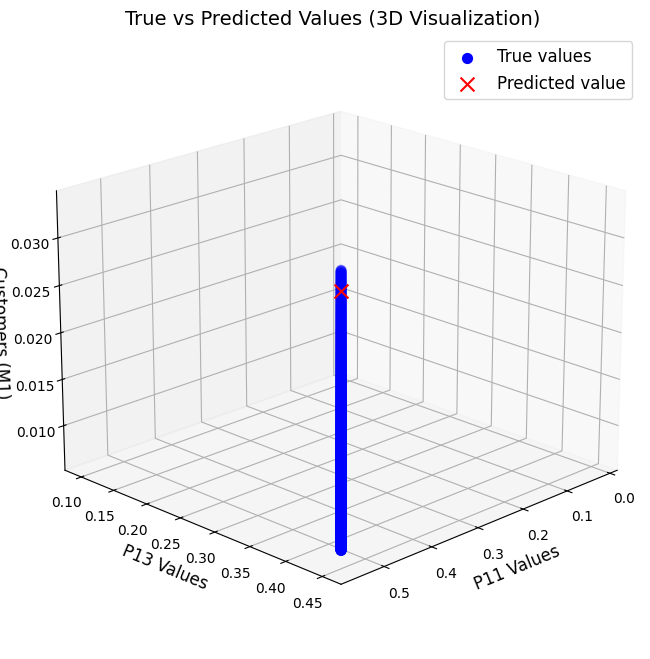

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Списки для хранения истинных и предсказанных значений
true_values = []
predicted_values = []


fixed_p21, fixed_p23 = 0.4, 0.12

for p13, p11 in zip(valid_p13_values, valid_p11_values):
    input_vector = [p11, p13, fixed_p21, fixed_p23]
    _, true_customers, _, _ = run_model_with_convergence(model, input_vector)
    true_values.append(true_customers)
    lr_input_vector = [p11, p13, fixed_p21, fixed_p23]
    predicted_customers = linear_reg_model.predict(np.array(lr_input_vector).reshape(1, -1))
    predicted_values.append(predicted_customers[0])

# Создание фигуры и 3D-оси
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(valid_p11_values, valid_p13_values, true_values, c='blue', label='True values', s=50)

ax.scatter(valid_p11_values[-1], valid_p13_values[-1], predicted_values[-1], c='red', label='Predicted value', s=100, marker='x')
ax.set_xlabel('P11 Values', fontsize=12)
ax.set_ylabel('P13 Values', fontsize=12)
ax.set_zlabel('Customers (M1)', fontsize=12)

ax.legend(fontsize=12)

ax.grid(True)
ax.view_init(elev=20, azim=45)
plt.title("True vs Predicted Values (3D Visualization)", fontsize=14)
plt.show()

Подбираем оптимальную комбинацию p11,p12,p13.

In [58]:
from itertools import product

def calculate_cost(p11, p12, p13):
    cost_happy = (capital_cost_per_100_clients * (clients / 100) * p11) + (cost_per_client['happy'] * clients * p11)
    cost_neutral = cost_per_client['neutral'] * clients * p12
    cost_unhappy = cost_per_client['unhappy'] * clients * p13
    return cost_happy + cost_neutral + cost_unhappy

clients = 3300
capital_cost_per_100_clients = 100
cost_per_client = {'happy': 5, 'neutral': 1, 'unhappy': 4}

min_cost, best_combination = float('inf'), None


for p11, p13 in product(valid_p11_values, valid_p13_values):
    if p11 + p13 <= 1:  # Проверка допустимости комбинации
        p12 = 1 - p11 - p13
        total_cost = calculate_cost(p11, p12, p13)

        if total_cost < min_cost:
            min_cost = total_cost
            best_combination = (p11, p12, p13)

p11, p12, p13 = best_combination
p11_rounded = round(p11, 4)
p12_rounded = round(p12, 4)
p13_rounded = round(p13, 4)
min_cost_rounded = round(min_cost, 4)

print(f"ЛУЧШАЯ КОМБИНАЦИЯ: p11={p11_rounded}, p12={p12_rounded}, p13={p13_rounded}")
print(f"НЕОБХОДИМЫЕ МИНИМАЛЬНЫЕ ЗАТРАТЫ: {min_cost_rounded} у.е.")

ЛУЧШАЯ КОМБИНАЦИЯ: p11=0.0156, p12=0.8844, p13=0.1
НЕОБХОДИМЫЕ МИНИМАЛЬНЫЕ ЗАТРАТЫ: 4547.0345 у.е.
